# Import

In [17]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

SEED = 1516

In [18]:
train = pd.read_csv('training_dataset.csv')
test = pd.read_csv('validation_set.csv')
train = train.drop(columns=['customer_number'])
test = test.drop(columns=['customer_number'])

target = 'berlangganan_deposito'

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22916 entries, 0 to 22915
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   usia                          22916 non-null  int64  
 1   pekerjaan                     22916 non-null  object 
 2   status_perkawinan             22916 non-null  object 
 3   pendidikan                    22916 non-null  object 
 4   gagal_bayar_sebelumnya        22916 non-null  object 
 5   pinjaman_rumah                22916 non-null  object 
 6   pinjaman_pribadi              22916 non-null  object 
 7   jenis_kontak                  22916 non-null  object 
 8   bulan_kontak_terakhir         22916 non-null  object 
 9   hari_kontak_terakhir          22916 non-null  object 
 10  jumlah_kontak_kampanye_ini    22916 non-null  int64  
 11  hari_sejak_kontak_sebelumnya  22916 non-null  int64  
 12  jumlah_kontak_sebelumnya      22916 non-null  int64  
 13  h

In [20]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
usia,22916.0,40.016233,10.438059,17.000,32.000,38.000,47.000,98.000
jumlah_kontak_kampanye_ini,22916.0,2.561878,2.794178,1.000,1.000,2.000,3.000,42.000
hari_sejak_kontak_sebelumnya,22916.0,962.210377,187.566774,0.000,999.000,999.000,999.000,999.000
jumlah_kontak_sebelumnya,22916.0,0.170143,0.490611,0.000,0.000,0.000,0.000,7.000
tingkat_variasi_pekerjaan,22916.0,0.077915,1.576176,-3.400,-1.800,1.100,1.400,1.400
indeks_harga_konsumen,22916.0,93.576541,0.580586,92.201,93.075,93.876,93.994,94.767
indeks_kepercayaan_konsumen,22916.0,-40.485717,4.641091,-50.800,-42.700,-41.800,-36.400,-26.900
suku_bunga_euribor_3bln,22916.0,3.617890,1.737591,0.634,1.344,4.857,4.961,5.045
jumlah_pekerja,22916.0,5166.773124,72.479698,4963.600,5099.100,5191.000,5228.100,5228.100
berlangganan_deposito,22916.0,0.114069,0.317902,0.000,0.000,0.000,0.000,1.000


In [21]:
# Get all object columns
obj_columns = train.select_dtypes(include=['object']).columns

# Loop through each object column and display unique values and their counts
for col in obj_columns:
    print(f"\n{col}:")
    print(train[col].value_counts())
    print(f"Total unique values: {train[col].nunique()}")


pekerjaan:
pekerjaan
sosial media specialis    5755
pekerja kasar             5191
teknisi                   3709
penyedia jasa             2195
manajer                   1653
pensiunan                  968
entrepreneur               815
pemilik bisnis             784
asisten rumah tangga       578
pengangguran               561
mahasiswa                  514
unknown                    193
Name: count, dtype: int64
Total unique values: 12

status_perkawinan:
status_perkawinan
menikah    13858
lajang      6445
cerai       2566
unknown       47
Name: count, dtype: int64
Total unique values: 4

pendidikan:
pendidikan
Pendidikan Tinggi    6699
SMA                  5403
SMP                  3337
Diploma              2881
Tidak Tamat SD       2284
SD                   1308
unknown               992
TIDAK SEKOLAH          12
Name: count, dtype: int64
Total unique values: 8

gagal_bayar_sebelumnya:
gagal_bayar_sebelumnya
no         18169
unknown     4745
yes            2
Name: count, dtype: i

# Baseline Model

## Split to train and validation

In [22]:
train, val = train_test_split(train, test_size=0.2, random_state=SEED, stratify=train[target])

X_train = train.drop(columns=[target])
y_train = train[target]
X_val = val.drop(columns=[target])
y_val = val[target]

## Encode for lgbm and xgb

In [ ]:
le = LabelEncoder()

X_train_le = X_train.copy()
X_val_le = X_val.copy()

for col in obj_columns:
    X_train_le[col] = le.fit_transform(X_train[col])
    X_val_le[col] = le.transform(X_val[col])

TypeError: LabelEncoder() takes no arguments

## Modelling

In [ ]:

ctb = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    cat_features=obj_columns.tolist(),
    eval_metric='AUC',
    random_seed=SEED,
    verbose=100,
    task_type='GPU',  # Use GPU for training
    devices='0'  # Adjust based on your GPU setup
)

lgb = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    num_leaves=31,
    random_state=SEED,
    device = 'gpu',
    gpu_platform_id=0,  # Adjust based on your GPU setup
    gpu_device_id=0  # Adjust based on your GPU setup
)


xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    random_state=SEED,
    tree_method='hist',  # Use GPU for training
    device='cuda',
    eval_metric='auc',
)

## Fit

In [ ]:
ctb.fit(
    X_train, 
    y_train, 
    eval_set=(X_val, y_val), 
    early_stopping_rounds=100,
    verbose=100
)

lgb.fit(
    X_train_le,
    y_train,
    eval_set=(X_val_le, y_val),
    categorical_feature=obj_columns.tolist(),
    eval_metric='auc',
)

xgb.fit(
    X_train_le,
    y_train,
    eval_set=[(X_val_le, y_val)],
    verbose=100
)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7726706	best: 0.7726706 (0)	total: 50.2ms	remaining: 50.1s
100:	test: 0.7929124	best: 0.7931468 (79)	total: 3.03s	remaining: 27s
200:	test: 0.7933653	best: 0.7938077 (151)	total: 6.08s	remaining: 24.2s
300:	test: 0.7943974	best: 0.7943974 (300)	total: 9.16s	remaining: 21.3s
400:	test: 0.7933392	best: 0.7943974 (300)	total: 12.2s	remaining: 18.3s
bestTest = 0.7943974137
bestIteration = 300
Shrink model to first 301 iterations.
[LightGBM] [Info] Number of positive: 2091, number of negative: 16241
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 18332, number of used features: 20
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 5060 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

/home/semiqolonn/miniforge3/envs/rapids/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:46:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744338762521/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


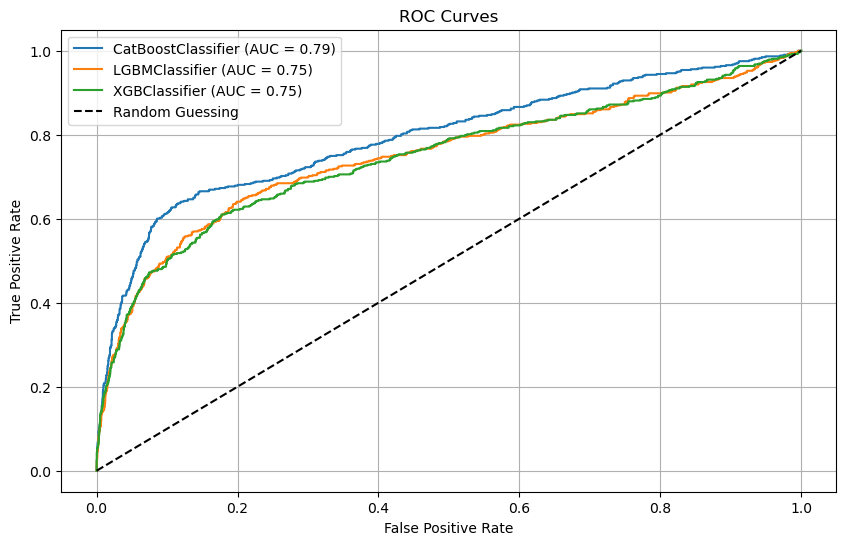

/tmp/ipykernel_608707/2963967537.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(precision, recall)
/tmp/ipykernel_608707/2963967537.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(precision, recall)
/tmp/ipykernel_608707/2963967537.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(precision, recall)


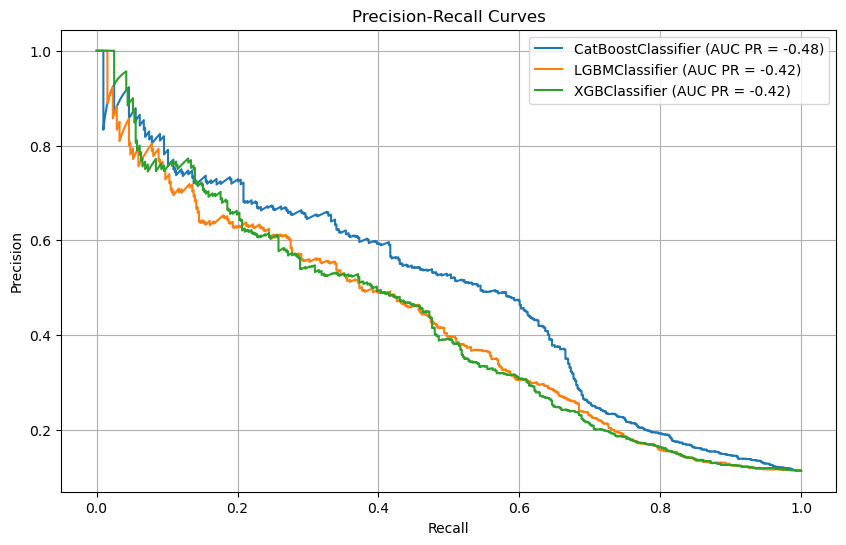

In [ ]:
# make 1 plot with 3 lines for each model
def plot_roc_curves(models, X_val, X_val_le, y_val):
    plt.figure(figsize=(10, 6))
    
    for model in models:
        if model == ctb:
            y_proba = model.predict_proba(X_val)[:, 1]
        else:
            y_proba = model.predict_proba(X_val_le)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        roc_auc = roc_auc_score(y_val, y_proba)
        plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid()
    plt.show()

plot_roc_curves([ctb, lgb, xgb], X_val, X_val_le, y_val)

def plot_precision_recall_curves(models, X_val, X_val_le, y_val):
    plt.figure(figsize=(10, 6))
    
    for model in models:
        if model == ctb:
            y_proba = model.predict_proba(X_val)[:, 1]
        else:
            y_proba = model.predict_proba(X_val_le)[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, y_proba)
        auc_pr = np.trapz(precision, recall)
        plt.plot(recall, precision, label=f'{model.__class__.__name__} (AUC PR = {auc_pr:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.grid()
    plt.show()

plot_precision_recall_curves([ctb, lgb, xgb], X_val, X_val_le, y_val)

# Weighted Model

## Calculate class weights and scale_pos

In [ ]:
classcount = y_train.value_counts()

# calculate class weights for lgbm and catboost
classweights = {0: classcount[1] / classcount[0], 1: 1.0}

# calculate scale_pos_weight for xgboost
scaleposweight = classcount[0] / classcount[1]

print(f"Class Weights: {classweights}")
print(f"Scale Pos Weight: {scaleposweight}")

Class Weights: {0: np.float64(0.1287482297888061), 1: 1.0}
Scale Pos Weight: 7.767097082735534


## Modelling

In [ ]:
# For the weighted models, change random_seed=42 to SEED:
ctb = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    cat_features=obj_columns.tolist(),
    eval_metric='AUC',
    random_seed=SEED,  # Changed from 42 to SEED
    verbose=100,
    class_weights=classweights,
    task_type='GPU',
    devices='0'
)

lgb = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    num_leaves=31,
    random_state=SEED,  # Changed from 42 to SEED
    class_weight=classweights,
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0
)

xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    random_state=SEED,  # Changed from 42 to SEED
    scale_pos_weight=scaleposweight,
    tree_method='hist',
    device='cuda',
    eval_metric='auc'
)

In [ ]:
ctb.fit(
    X_train, 
    y_train, 
    eval_set=(X_val, y_val), 
    early_stopping_rounds=100,
    verbose=100,
)

lgb.fit(
    X_train_le,
    y_train,
    eval_set=(X_val_le, y_val),
    categorical_feature=obj_columns.tolist(),
    eval_metric='auc',
)

xgb.fit(
    X_train_le,
    y_train,
    eval_set=[(X_val_le, y_val)],
    verbose=100
)




Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7768114	best: 0.7768114 (0)	total: 30.2ms	remaining: 30.1s
100:	test: 0.7938232	best: 0.7944339 (16)	total: 3.03s	remaining: 27s
bestTest = 0.7944338918
bestIteration = 16
Shrink model to first 17 iterations.
[LightGBM] [Info] Number of positive: 2091, number of negative: 16241
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 18332, number of used features: 20
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 5060 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (0.28 MB) transferred to GPU in 0.000644 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from sco

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

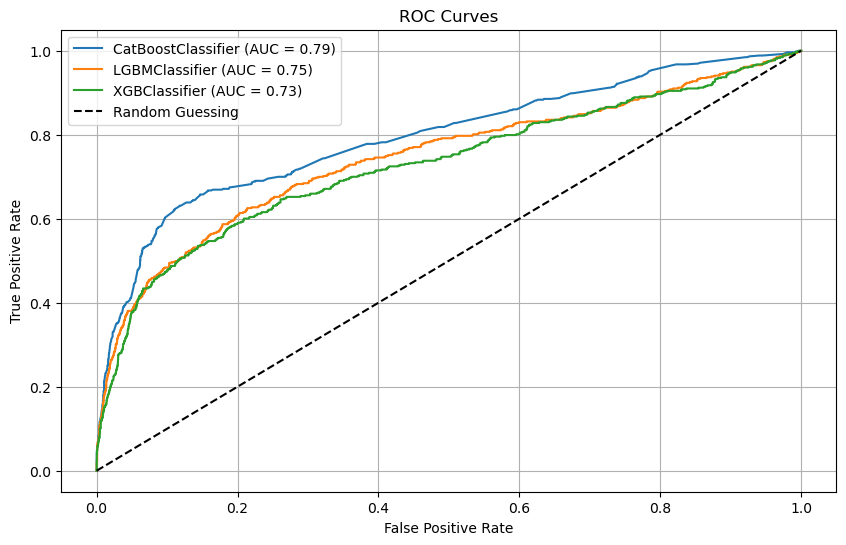

/tmp/ipykernel_608707/2963967537.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(precision, recall)
/tmp/ipykernel_608707/2963967537.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(precision, recall)
/tmp/ipykernel_608707/2963967537.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(precision, recall)


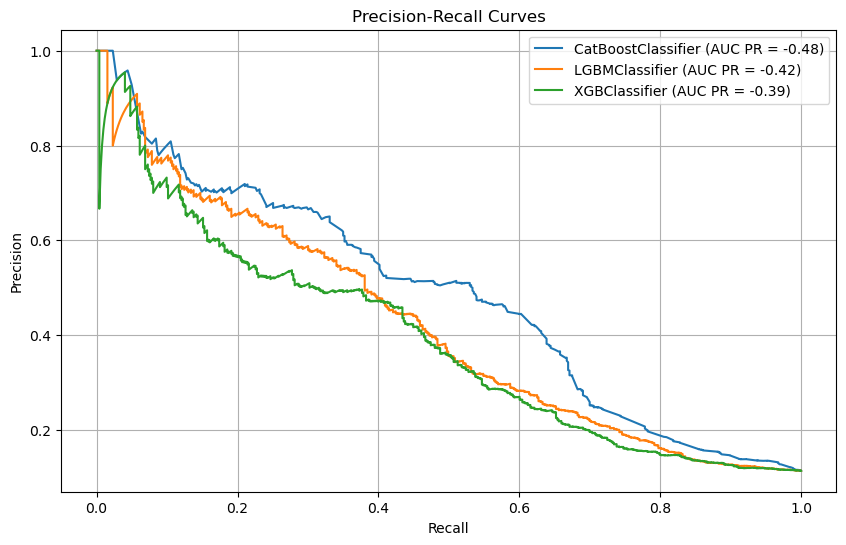

In [ ]:
# make 1 plot with 3 lines for each model
def plot_roc_curves(models, X_val, X_val_le, y_val):
    plt.figure(figsize=(10, 6))
    
    for model in models:
        if model == ctb:
            y_proba = model.predict_proba(X_val)[:, 1]
        else:
            y_proba = model.predict_proba(X_val_le)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        roc_auc = roc_auc_score(y_val, y_proba)
        plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid()
    plt.show()

plot_roc_curves([ctb, lgb, xgb], X_val, X_val_le, y_val)

def plot_precision_recall_curves(models, X_val, X_val_le, y_val):
    plt.figure(figsize=(10, 6))
    
    for model in models:
        if model == ctb:
            y_proba = model.predict_proba(X_val)[:, 1]
        else:
            y_proba = model.predict_proba(X_val_le)[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, y_proba)
        auc_pr = np.trapz(precision, recall)
        plt.plot(recall, precision, label=f'{model.__class__.__name__} (AUC PR = {auc_pr:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.grid()
    plt.show()

plot_precision_recall_curves([ctb, lgb, xgb], X_val, X_val_le, y_val)